# Pipeline for High-z Radio Galaxies 26: Star/No-star classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=14)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Get estimators list

In [13]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

***

## Reading data

In [14]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [15]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

In [16]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [21]:
# full_catalog_df.describe()

#### Select only spectroscopically confirmed sources: stars, galaxies, and AGN

In [22]:
full_catalog_df.columns

Index(['spCl', 'band_num', 'is_str', 'is_AGN', 'is_SDSS_gal', 'is_gal',
       'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag',
       'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r',
       'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K',
       'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K',
       'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2'],
      dtype='object')

In [23]:
np.unique(full_catalog_df.loc[:, 'spCl'])

array(['      ', 'GALAXY', 'QSO   ', 'STAR  '], dtype=object)

In [24]:
full_catalog_df = full_catalog_df.loc[full_catalog_df.loc[:, 'spCl'] != '      ']

Inverse calculation of star presence, for selecting those which are not stars.

In [25]:
full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)

In [26]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_str = np.sum(full_catalog_df.loc[:, 'is_str'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, {n_is_gal} are identified as galaxies,\n' +\
          f'and {n_is_str} are stars.')

In this dataset, with 81059 elements,
17322 of them are marked as AGN, 55153 are identified as galaxies,
and 6770 are stars.


---

## Possible correlations

In [27]:
print(full_catalog_df.columns.to_list())

['spCl', 'band_num', 'is_str', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [28]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [29]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [30]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'spCl'])

## Split data: Test, Train, Validation

In [31]:
target_feat = 'is_str'

In [32]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2, random_state=seed, stratify=full_catalog_df.loc[:, target_feat])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (81059, 39)
Data for Modeling (Train and Test): (64847, 39)
Unseen Data For Validation: (16212, 39)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [33]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_01.txt', X=val_idx, header='Indices from first AGN training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [34]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [35]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [36]:
rsd_vals

is_str      331.261176
z_y         209.631823
i_z         197.325184
r_i         105.902880
g_r          90.148678
g_i          68.619300
J_H          44.972118
H_K          36.182517
w2_w3        31.647800
band_num     22.351158
w3_w4        16.088114
gmag          7.403380
rmag          7.005437
g/J           6.540193
ymag          6.412518
imag          6.362461
zmag          6.321031
r/H           6.113153
i/K           5.920662
W1mproPM      5.597043
w1/w4         5.408452
z/W1          5.295778
y/W2          5.170070
w1/w3         4.975596
W2mproPM      4.641808
w2/w4         4.407110
r/z           3.447530
i/y           2.863171
W3mag         2.420230
Hmag          2.187158
Jmag          2.181718
NUVmag        1.950369
FUV/K         1.698043
Kmag          1.335800
J/K           1.213320
W4mag         1.067674
FUVmag        0.758201
FUV_NUV     -35.349822
w1_w2      -168.863018
dtype: float64

In [37]:
correlation = norm_train_test_df.corr()

In [38]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [39]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [40]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [41]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [42]:
list_drop_corr

['i/K',
 'w1/w4',
 'w2/w4',
 'Jmag',
 'g/J',
 'r/H',
 'FUV_NUV',
 'W3mag',
 'zmag',
 'W2mproPM',
 'w1/w3',
 'imag',
 'J/K',
 'Kmag',
 'rmag',
 'Hmag',
 'W1mproPM',
 'g_i',
 'y/W2']

In [43]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [44]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [45]:
corr_discard = norm_train_test_discard.corr()

In [46]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
          ymag        0.724284
r/z       r_i         0.711460
FUVmag    NUVmag      0.690872
ymag      gmag        0.669240
gmag      band_num    0.642509
ymag      H_K         0.601868
i_z       i/y         0.582016
z_y       i/y         0.565699
gmag      H_K         0.543262
w2_w3     ymag        0.532050
i_z       r/z         0.530179
band_num  H_K         0.509812
gmag      z/W1        0.501833
w3_w4     NUVmag      0.495362
dtype: float64

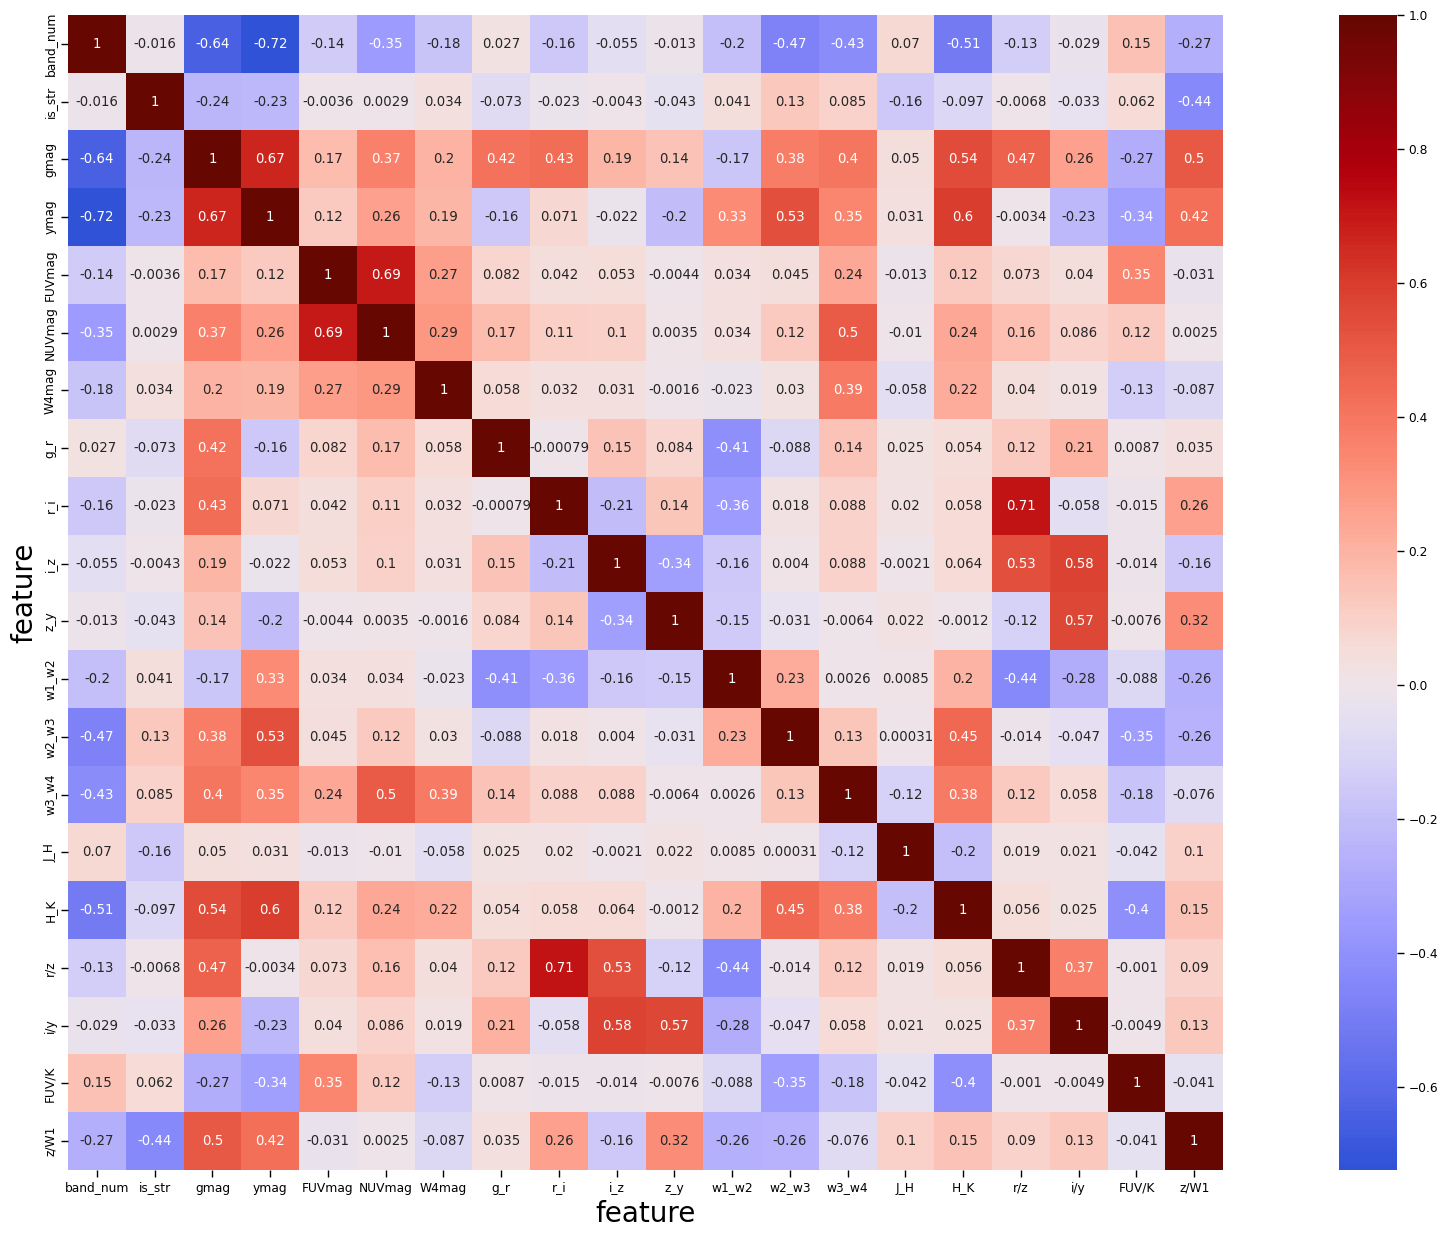

In [47]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')
plt.show()

In [48]:
norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [49]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [50]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
FUV/K     FUV/K       1.000000
band_num  gmag        0.406135
          ymag        0.383490
r/z       r_i         0.359915
r_i       r/z         0.350780
NUVmag    FUVmag      0.349539
FUV/K     FUVmag      0.348321
J_H       H_K         0.284014
ymag      H_K         0.262114
J_H       band_num    0.224603
band_num  g_r         0.207948
H_K       band_num    0.206525
          ymag        0.196796
g_r       gmag        0.177508
ymag      gmag        0.171770
band_num  NUVmag      0.167501
J_H       ymag        0.166206
H_K       gmag        0.162901
ymag      band_num    0.155437
band_num  w2_w3       0.144751
dtype: float64

In [51]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [52]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [53]:
list_drop_pps = []

In [54]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [55]:
list_drop_pps

[]

In [56]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [57]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=seed)

In [58]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,H_K,is_str,3.687458e-02,classification,True,weighted F1,0.886917,0.891087,DecisionTreeClassifier()
1,z/W1,is_str,3.384482e-02,classification,True,weighted F1,0.886917,0.890744,DecisionTreeClassifier()
2,band_num,is_str,3.975659e-07,classification,True,weighted F1,0.886917,0.886917,DecisionTreeClassifier()
3,gmag,is_str,0.000000e+00,classification,True,weighted F1,0.886917,0.878454,DecisionTreeClassifier()
4,ymag,is_str,0.000000e+00,classification,True,weighted F1,0.886917,0.873288,DecisionTreeClassifier()
5,FUVmag,is_str,0.000000e+00,classification,True,weighted F1,0.886917,0.886618,DecisionTreeClassifier()
6,NUVmag,is_str,0.000000e+00,classification,True,weighted F1,0.886917,0.885191,DecisionTreeClassifier()
7,W4mag,is_str,0.000000e+00,classification,True,weighted F1,0.886917,0.886518,DecisionTreeClassifier()
8,g_r,is_str,0.000000e+00,classification,True,weighted F1,0.886917,0.870465,DecisionTreeClassifier()
9,r_i,is_str,0.000000e+00,classification,True,weighted F1,0.886917,0.874326,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [59]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta
# final_feats.remove('FUVmag')  # After Boruta

In [60]:
feats_2_discard = list_drop_corr + list_drop_pps #  + ['FUVmag']

Boruta discards one feature.

In [61]:
exp_AGN = pyc.setup(data=train_test_df, target=target_feat, session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,is_str
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(64847, 39)"
5,Missing Values,False
6,Numeric Features,19
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [62]:
pyc.get_config('X').columns

Index(['band_num', 'gmag', 'ymag', 'FUVmag', 'NUVmag', 'W4mag', 'g_r', 'r_i',
       'i_z', 'z_y', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'r/z', 'i/y',
       'FUV/K', 'z/W1'],
      dtype='object')

In [63]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [64]:
metric_to_optimize   = 'Recall'

In [65]:
final_selection_clf  = ['lightgbm', 'catboost', 'xgboost', 'et', 'rf', 'dummy']  # knn, qda do not have feature importances
n_models             = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_to_optimize)  # 1:15 hour for used_models_clf
# top_model_AGN = pyc.compare_models(n_select=n_models, exclude=['knn', 'qda'], sort=metric_to_optimize)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9804,0.9839,0.8256,0.9317,0.8753,0.8647,0.8666,29.0310
catboost,CatBoost Classifier,0.9805,0.9835,0.8251,0.9339,0.8760,0.8655,0.8675,1.9110
xgboost,Extreme Gradient Boosting,0.9797,0.9830,0.8246,0.9246,0.8716,0.8606,0.8623,8.8930
et,Extra Trees Classifier,0.9794,0.9758,0.8045,0.9406,0.8672,0.8561,0.8592,0.2220
rf,Random Forest Classifier,0.9798,0.9767,0.8040,0.9465,0.8693,0.8585,0.8619,0.7530
dt,Decision Tree Classifier,0.9628,0.8820,0.7848,0.7740,0.7792,0.7589,0.7590,0.1300
gbc,Gradient Boosting Classifier,0.9735,0.9734,0.7402,0.9276,0.8232,0.8091,0.8152,1.7370
nb,Naive Bayes,0.8735,0.8839,0.7270,0.3709,0.4905,0.4271,0.4591,0.1580
ada,Ada Boost Classifier,0.9641,0.9622,0.6658,0.8759,0.7562,0.7372,0.7455,0.3840
lr,Logistic Regression,0.9473,0.9307,0.5162,0.7791,0.6208,0.5938,0.6084,0.3370


Thus, we select `catboost` as meta learner.

Then, we stack the models.

In [66]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0], optimize=metric_to_optimize)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9828,0.9886,0.8575,0.9312,0.8929,0.8835,0.8844
1,0.9795,0.9847,0.8316,0.9159,0.8717,0.8606,0.8618
2,0.9800,0.9852,0.8364,0.9162,0.8745,0.8636,0.8647
3,0.9817,0.9886,0.8522,0.9229,0.8861,0.8762,0.8770
4,0.9786,0.9807,0.8153,0.9196,0.8643,0.8528,0.8546
5,0.9791,0.9812,0.8100,0.9303,0.8660,0.8547,0.8571
6,0.9817,0.9819,0.8285,0.9458,0.8833,0.8734,0.8756
7,0.9773,0.9798,0.8100,0.9083,0.8563,0.8441,0.8457
8,0.9828,0.9894,0.8443,0.9440,0.8914,0.8821,0.8837


In [67]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping='asha', optimize=metric_to_optimize,\
                               search_library='tune-sklearn', search_algorithm='random')  # 20  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9817,0.9894,0.8470,0.9277,0.8855,0.8756,0.8767
1,0.9806,0.9859,0.8342,0.9269,0.8781,0.8676,0.8690
2,0.9826,0.9879,0.8602,0.9261,0.8919,0.8825,0.8832
3,0.9813,0.9878,0.8496,0.9200,0.8834,0.8732,0.8741
4,0.9800,0.9809,0.8232,0.9286,0.8727,0.8619,0.8637
5,0.9808,0.9807,0.8259,0.9371,0.8780,0.8676,0.8697
6,0.9819,0.9831,0.8311,0.9459,0.8848,0.8751,0.8772
7,0.9764,0.9816,0.7968,0.9096,0.8495,0.8368,0.8389
8,0.9819,0.9891,0.8443,0.9329,0.8864,0.8766,0.8779


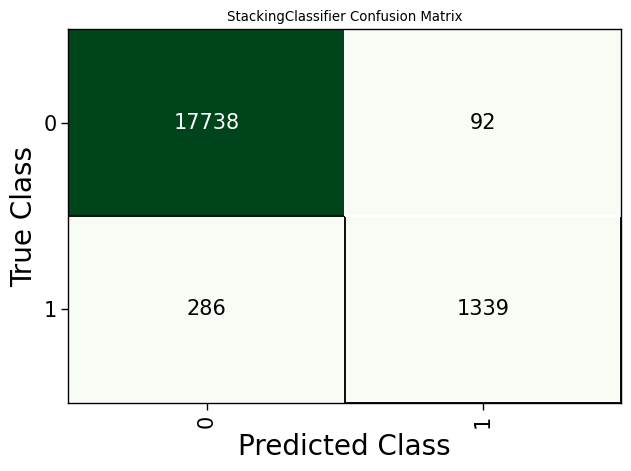

In [68]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

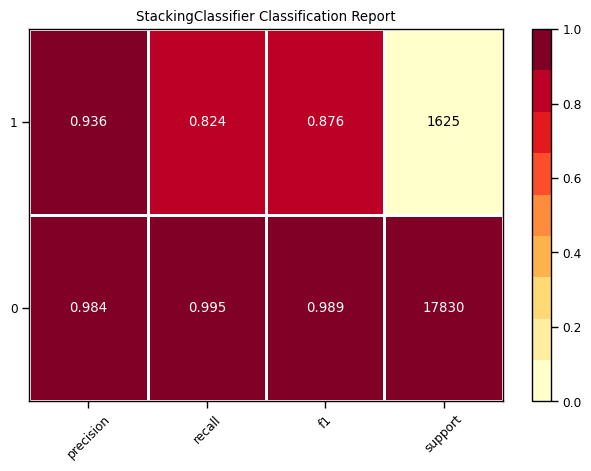

In [69]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

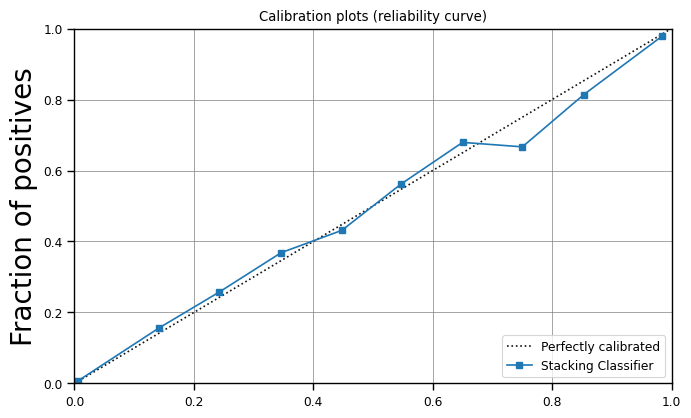

In [70]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

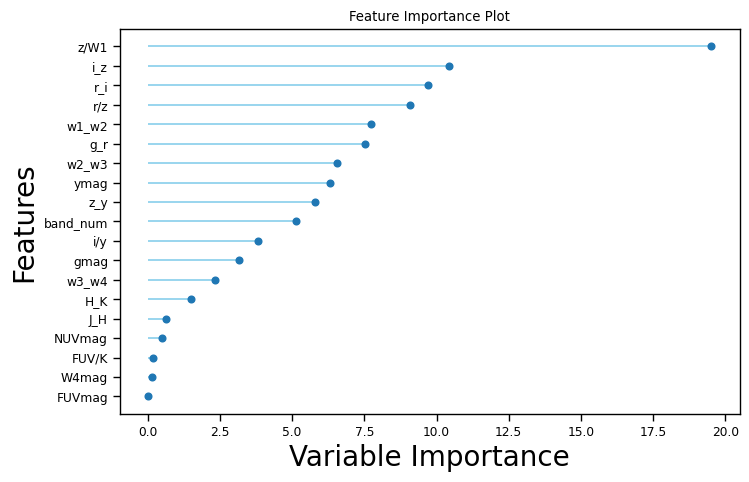

In [71]:
pyc.plot_model(tuned_AGN_clf.estimators_[0], plot='feature_all')

In [72]:
pyc.plot_model(tuned_AGN_clf.final_estimator, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.2
max_depth,-1
min_child_samples,91
min_child_weight,0.001
min_split_gain,0.9
n_estimators,270


In [73]:
plt.rcParams.update(plt.rcParamsDefault)

In [74]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9806,0.9852,0.8240,0.9357,0.8763,0.8658,0.8679


,band_num,gmag,ymag,FUVmag,NUVmag,W4mag,g_r,r_i,i_z,z_y,...,J_H,H_K,r/z,i/y,FUV/K,z/W1,is_str,Label,Score_0,Score_1
0,-1.233772,1.345611,1.651062,0.148909,0.328154,0.171206,-0.973188,2.018147,0.331471,-1.781911,...,-0.02041,0.360386,1.908120,-1.177591,-0.071755,0.531780,0,0,0.9944,0.0056
1,-1.612648,0.054857,0.261374,0.148909,0.328154,0.171206,-0.113621,-0.539255,-0.331165,0.982656,...,-0.02041,0.360386,-0.734299,0.556305,-0.071755,-0.659144,0,1,0.4307,0.5693
2,-0.061636,0.004723,-0.567940,0.148909,0.328154,0.171206,0.694138,0.236975,-0.109744,0.575324,...,-0.02041,0.360386,0.168462,0.461341,-0.071755,0.657145,0,0,0.9996,0.0004
3,-0.459829,1.345611,-0.286383,0.148909,0.328154,0.171206,2.558298,0.113997,0.582432,-0.036668,...,-0.02041,0.360386,0.535119,0.497203,-0.071755,0.557315,0,0,0.9997,0.0003
4,-0.459829,-0.293682,1.651062,0.148909,0.328154,0.171206,-1.165431,-0.554188,0.184463,-2.150911,...,-0.02041,0.360386,-0.368059,-1.585887,-0.071755,-0.432872,0,0,0.9960,0.0040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19450,-1.987347,1.345611,1.651062,0.148909,0.328154,0.171206,-0.973188,-0.793270,1.079119,1.306048,...,-0.02041,0.360386,-0.049629,1.763583,-0.071755,2.007874,0,0,0.9677,0.0323
19451,0.347011,-1.065360,-0.196368,0.148909,0.328154,0.171206,-1.111060,-0.563053,-0.695740,0.150162,...,-0.02041,0.360386,-1.029680,-0.503705,-0.071755,-0.724738,0,0,0.9985,0.0015
19452,-0.459829,1.345611,0.014394,0.148909,0.328154,0.171206,1.292715,0.819406,0.520444,0.152356,...,-0.02041,0.360386,1.066199,0.579562,-0.071755,1.178148,0,0,0.9993,0.0007
19453,-0.459829,1.345611,0.207771,0.148909,0.328154,0.171206,1.539822,0.757994,0.174064,-0.247860,...,-0.02041,0.360386,0.787716,-0.060512,-0.071755,0.419936,0,0,0.9966,0.0034


In [75]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9806,0.9852,0.8240,0.9357,0.8763,0.8658,0.8679


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [ ]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

In [77]:
if save_model_flag:
    pyc.save_model(final_AGN_clf, 'models/classification_star_no_star_jun_30_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('../../models/config_classification_star_no_star_jun_30_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [59]:
if load_model_flag:
    if use_5sigma:
        final_AGN_clf = pyc.load_model('models/classification_star_no_star_jun_30_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [60]:
estimators_list = get_base_estimators_names(final_AGN_clf)

In [61]:
extended_data_AGN = validation_df.loc[:, get_final_column_names(final_AGN_clf, validation_df)].copy()
extended_idx_AGN  = extended_data_AGN.index
initial_cols_AGN  = extended_data_AGN.columns
extended_cols_AGN = extended_data_AGN.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_AGN = extended_cols_AGN.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [62]:
print('Running data pre-processing:\n')
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_AGN_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_AGN = method.transform(extended_data_AGN)
extended_data_AGN_df = pd.DataFrame(extended_data_AGN, columns=extended_cols_AGN, index=extended_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [63]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    if hasattr(final_AGN_clf.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_AGN_clf.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_AGN_clf.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_AGN_clf.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_AGN.loc[:, extended_cols_AGN].std(axis=0)
else:
    if hasattr(final_AGN_clf.final_estimator_, 'feature_importances_'):
        importances_coef = final_AGN_clf.final_estimator_.feature_importances_
    elif hasattr(final_AGN_clf.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_AGN_clf.final_estimator_.coef_)) *\
                                     extended_data_AGN.loc[:, extended_cols_AGN].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_AGN, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [64]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_AGN_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_AGN_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_AGN_clf.estimators
    estimators_list_ = final_AGN_clf.estimators_

In [65]:
base_models_names = [model[0] for model in estimators_list]

In [66]:
coef_sorted_base_df = {}

In [67]:
for model, model_fit in zip(base_models_names, estimators_list_):
    coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                 'Importance': model_fit.feature_importances_})
    coef_sorted_base_df[model] = (
    coef_base_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN.drop(base_models_names)))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [68]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [69]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for catboost...
Calculating for xgboost...
Calculating for et...
Calculating for rf...


catboost              xgboost                   et                   rf  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0       z/W1  20.147179      z/W1  24.912785      z/W1  17.052704      z/W1   
1        i_z  10.246367     w3_w4  11.817050      gmag  10.519158       r/z   
2        r/z   9.395729       i/y  10.464411      ymag   9.382041      ymag   
3        r_i   9.012663       r/z   8.778207       r/z   8.835404      gmag   
4        g_r   7.605872  band_num   6.889019     w2_w3   7.359050       r_i   
5      w1_w2   7.556796     w2_w3   5.689790       r_i   6.816273       i/y   
6        z_y   6.451532      ymag   3.988108       i/y   6.364187       i_z   
7       ymag   6.408142       z_y   3.606756  band_num   6.003877     w2_w3   
8   band_num   5.952446       i_z   3.553476       i_z   5.436874       g_r   
9      w2_w3   5.914582       r_i   3.465523     w1_w2   5.434293       z_y   
10       i/y   3.679868       g_r   3.284007       g_r   5.377830  band_num   
11      gmag   3.057740     w1_w2   3.244715       z_y   4.237082     w1_w2   
12     w3_w4   1.555059       H_K   3.019636     w3_w4   2.074929       H_K   
13       H_K   1.336650       J_H   2.148431       J_H   1.511146     w3_w4   
14       J_H   0.665441      gmag   2.004710       H_K   1.401910       J_H   
15    NUVmag   0.638120    NUVmag   1.790792     FUV/K   0.790943     FUV/K   
16     FUV/K   0.365208     FUV/K   1.113962    NUVmag   0.659518    NUVmag   
17    FUVmag   0.010606     W4mag   0.228621     W4mag   0.552165     W4mag   
18     W4mag   0.000000    FUVmag   0.000000    FUVmag   0.190614    FUVmag   

               
   Importance  
0   23.148778  
1   10.198464  
2    8.663251  
3    7.885015  
4    7.252891  
5    6.518275  
6    6.485989  
7    5.423182  
8    5.264793  
9    5.041227  
10   4.455674  
11   4.336394  
12   1.699385  
13   1.361583  
14   1.191460  
15   0.486909  
16   0.317061  
17   0.224239  
18   0.045430

In [70]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,r_i,8.095781
1,g_r,8.038769
2,z/W1,7.924743
3,r/z,7.810718
4,et,7.525656
5,i_z,7.411631
6,xgboost,7.126568
7,z_y,7.012543
8,w1_w2,6.442417
9,ymag,5.758267


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
z/W1	20.193
i_z	10.098
r/z	9.392
r_i	8.920
g_r	7.520
w1_w2	7.463
ymag	6.435
z_y	6.389
band_num	5.948
w2_w3	5.922
i/y	3.799
gmag	3.167
w3_w4	1.658
H_K	1.357
J_H	0.693
NUVmag	0.646
FUV/K	0.378
FUVmag	0.013
W4mag	0.010


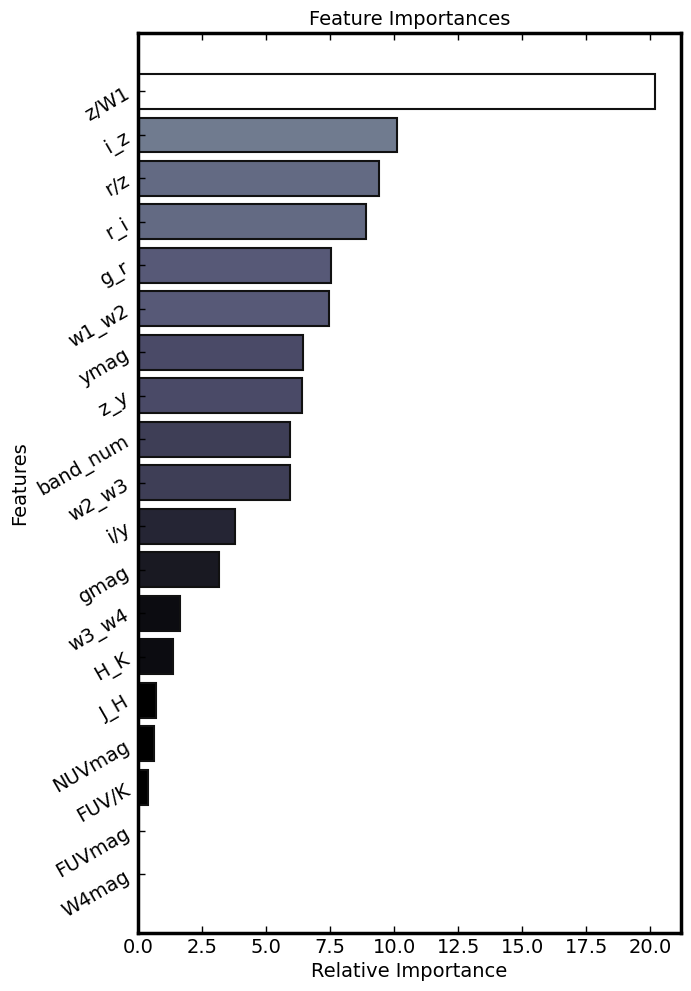

In [71]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_star_no_star_01.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

---

In [72]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=[target_feat]), train_test_df.loc[:, target_feat], False, target_feat
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=[target_feat]),
                train_test_df.loc[:, target_feat],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

#### Calculate optimal threshold for classification

In [73]:
AGN_naive_threshold       = 0.5

In [74]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_data_df,  probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)

#### Naive threshold metrics.

In [75]:
cm_mat_val_naive = np.array([[np.sum(np.array(validation_prediction_clf['is_str'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['is_str'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                             [np.sum(np.array(validation_prediction_clf['is_str'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['is_str'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

In [76]:
cm_mat_train_naive = np.array([[np.sum(np.array(train_prediction_clf['is_str'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['is_str'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                               [np.sum(np.array(train_prediction_clf['is_str'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['is_str'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [77]:
cm_mat_test_naive = np.array([[np.sum(np.array(test_prediction_clf['is_str'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['is_str'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(test_prediction_clf['is_str'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['is_str'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

In [78]:
cm_mat_train_test_naive = np.array([[np.sum(np.array(train_test_prediction_clf['is_str'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['is_str'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                                    [np.sum(np.array(train_test_prediction_clf['is_str'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['is_str'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

In [79]:
MCC_val_naive           = MCC_from_CM(cm_mat_val_naive)
ACC_val_naive           = ACC_from_CM(cm_mat_val_naive)
F1_val_naive            = F1_from_CM(cm_mat_val_naive)
Recall_val_naive        = Recall_from_CM(cm_mat_val_naive)

MCC_train_naive         = MCC_from_CM(cm_mat_train_naive)
ACC_train_naive         = ACC_from_CM(cm_mat_train_naive)
F1_train_naive          = F1_from_CM(cm_mat_train_naive)
Recall_train_naive      = Recall_from_CM(cm_mat_train_naive)

MCC_test_naive          = MCC_from_CM(cm_mat_test_naive)
ACC_test_naive          = ACC_from_CM(cm_mat_test_naive)
F1_test_naive           = F1_from_CM(cm_mat_test_naive)
Recall_test_naive       = Recall_from_CM(cm_mat_test_naive)

MCC_train_test_naive    = MCC_from_CM(cm_mat_train_test_naive)
ACC_train_test_naive    = ACC_from_CM(cm_mat_train_test_naive)
F1_train_test_naive     = F1_from_CM(cm_mat_train_test_naive)
Recall_train_test_naive = Recall_from_CM(cm_mat_train_test_naive)

naive_scores_array            = np.array([[F1_train_naive,      MCC_train_naive,      Recall_train_naive,      ACC_train_naive],\
                                          [F1_test_naive,       MCC_test_naive,       Recall_test_naive,       ACC_test_naive],\
                                          [F1_train_test_naive, MCC_train_test_naive, Recall_train_test_naive, ACC_train_test_naive],\
                                          [F1_val_naive,        MCC_val_naive,        Recall_val_naive,        ACC_val_naive]])

In [80]:
naive_scores_df = pd.DataFrame(data=naive_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [81]:
display(naive_scores_df)

,F1,MCC,Recall,ACC
Train,0.973073,0.970874,0.953718,0.995528
Test,0.970368,0.968118,0.949045,0.995323
Train+Test,0.972290,0.970075,0.952363,0.995466
Validation,0.899769,0.892089,0.861891,0.983962


#### Calibration curve

In [82]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

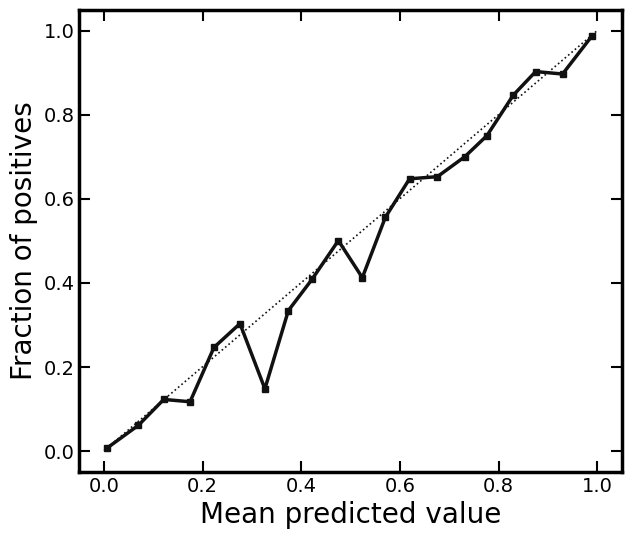

In [83]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='s', c='k', lw=2.5)
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

Calculate ROC AUC values and plots.

In [84]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [85]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99968
Area under the curve (ROC) for test       = 0.99970
Area under the curve (ROC) for train+test = 0.99969
Area under the curve (ROC) for validation = 0.98720


In [86]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

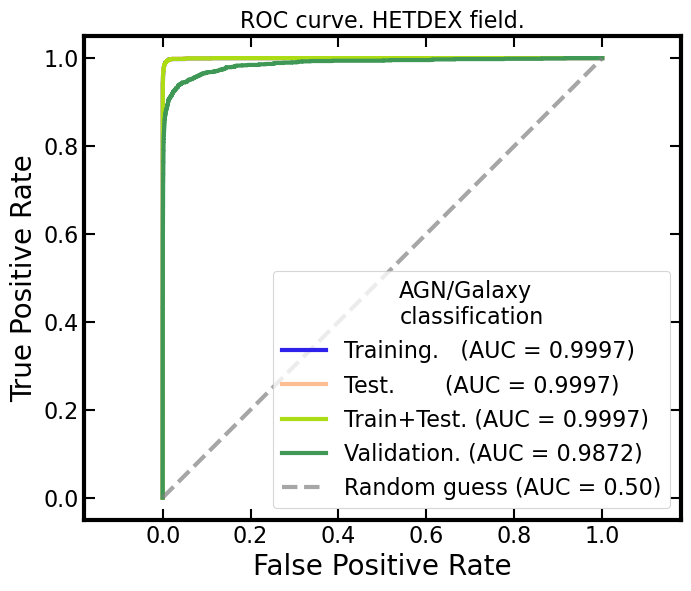

In [87]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.4f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.4f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), label=f"Train+Test. (AUC = {roc_auc_train_test:0.4f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.4f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='AGN/Galaxy\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

##### Find optimal threshold for each sub-set

In [88]:
opt_t_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_t_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_t_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_t_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [89]:
print(f'Optimal threshold from area under the curve (ROC) for training   = {opt_t_train:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for test       = {opt_t_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for train+test = {opt_t_train_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for validation = {opt_t_validation:.5f}')

Optimal threshold from area under the curve (ROC) for training   = 0.17284
Optimal threshold from area under the curve (ROC) for test       = 0.15735
Optimal threshold from area under the curve (ROC) for train+test = 0.15688
Optimal threshold from area under the curve (ROC) for validation = 0.07693


##### Precision-Recall curve

In [90]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [91]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_validation = auc(recall_validation, prec_validation)

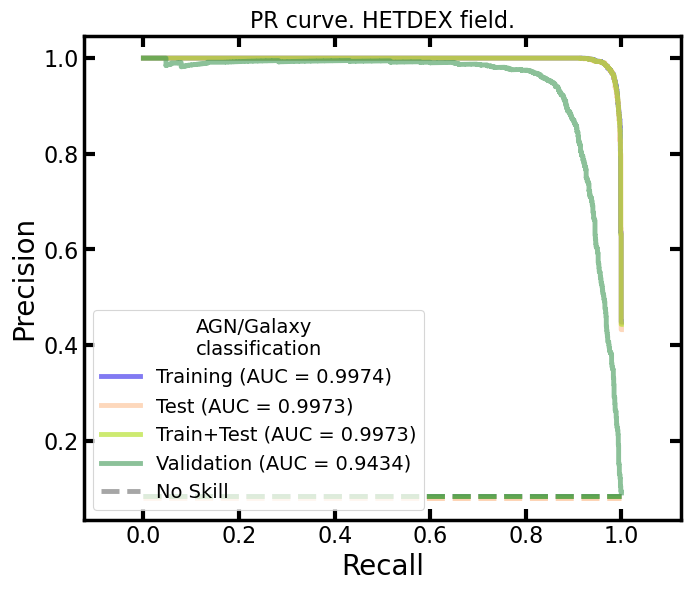

In [92]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, 'is_str'] == 1)      / len(train_prediction_clf.loc[:, 'is_str'])
no_skill_test       = np.sum(test_prediction_clf.loc[:, 'is_str'] == 1)       / len(test_prediction_clf.loc[:, 'is_str'])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, 'is_str'] == 1) / len(train_test_prediction_clf.loc[:, 'is_str'])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, 'is_str'] == 1) / len(validation_prediction_clf.loc[:, 'is_str'])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=3.0)
ax1.tick_params(which='minor', length=4, width=3.0)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/PR_curve_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [93]:
fscore_train      = (2 * prec_train      * recall_train)      / (prec_train      + recall_train)
fscore_test       = (2 * prec_test       * recall_test)       / (prec_test       + recall_test)
fscore_train_test = (2 * prec_train_test * recall_train_test) / (prec_train_test + recall_train_test)
fscore_validation = (2 * prec_validation * recall_validation) / (prec_validation + recall_validation)

In [94]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [95]:
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation:.5f}')

Optimal threshold from Precision-Recall curve for training   = 0.37441
Optimal threshold from Precision-Recall curve for test       = 0.44063
Optimal threshold from Precision-Recall curve for train+test = 0.37441
Optimal threshold from Precision-Recall curve for validation = 0.48234


---

In [96]:
AGN_pred_threshold = float(opt_t_PR_train_test) #  0.5

In [97]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_pred_threshold, raw_score=True)

Create confusion matrix with validation data.

In [98]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf[target_feat] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf[target_feat] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                       [np.sum(np.array(validation_prediction_clf[target_feat] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf[target_feat] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

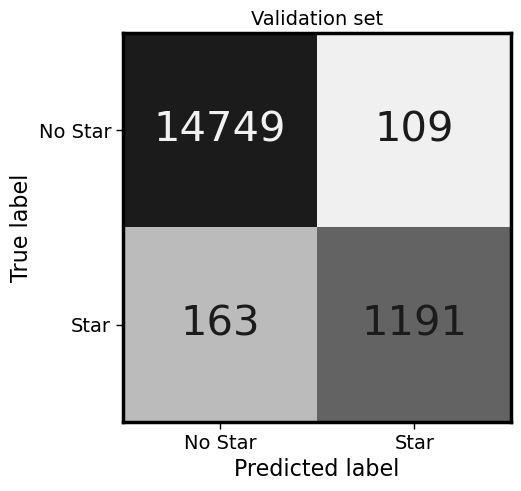

In [99]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No Star', 'Star'], log_stretch=True)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

In [100]:
MCC_radio_val    = MCC_from_CM(cm_mat_val)
ACC_radio_val    = ACC_from_CM(cm_mat_val)
F1_radio_val     = F1_from_CM(cm_mat_val)
Recall_radio_val = Recall_from_CM(cm_mat_val)

In [101]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_val:.4f}')
print(f'F1-score is                          F1 = {F1_radio_val:.4f}')
print(f'Recall is                           TPR = {Recall_radio_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.8886
Accuracy is                         ACC = 0.9832
F1-score is                          F1 = 0.8975
Recall is                           TPR = 0.8796


In [102]:
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_data_df,  probability_threshold=AGN_pred_threshold, raw_score=True)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=AGN_pred_threshold, raw_score=True)

In [103]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf[target_feat] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf[target_feat] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                         [np.sum(np.array(train_prediction_clf[target_feat] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf[target_feat] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [104]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf[target_feat] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf[target_feat] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                        [np.sum(np.array(test_prediction_clf[target_feat] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf[target_feat] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

In [105]:
cm_mat_train_test = np.array([[np.sum(np.array(train_test_prediction_clf[target_feat] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf[target_feat] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(train_test_prediction_clf[target_feat] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf[target_feat] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

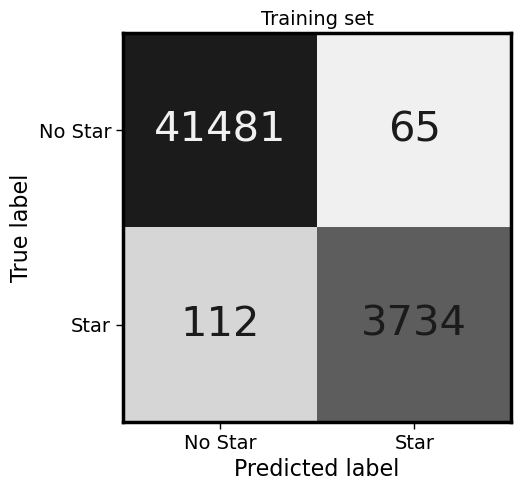

In [106]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No Star', 'Star'], log_stretch=True)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

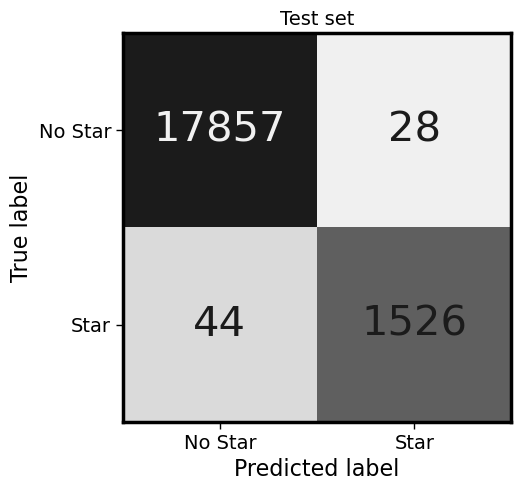

In [107]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No Star', 'Star'], log_stretch=True)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

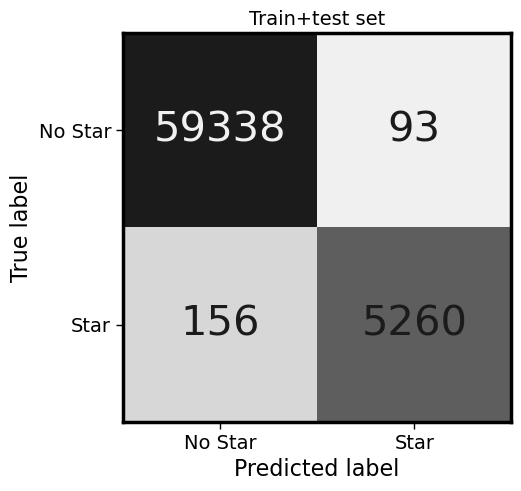

In [108]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No Star', 'Star'], log_stretch=True)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_test_classification_star_no_star_01.pdf', bbox_inches='tight')
plt.show()

In [109]:
MCC_radio_train    = MCC_from_CM(cm_mat_train)
ACC_radio_train    = ACC_from_CM(cm_mat_train)
F1_radio_train     = F1_from_CM(cm_mat_train)
Recall_radio_train = Recall_from_CM(cm_mat_train)

In [110]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_train:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_train:.4f}')
print(f'F1-score is                          F1 = {F1_radio_train:.4f}')
print(f'Recall is                           TPR = {Recall_radio_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.9747
Accuracy is                         ACC = 0.9961
F1-score is                          F1 = 0.9768
Recall is                           TPR = 0.9709


In [111]:
MCC_radio_test    = MCC_from_CM(cm_mat_test)
ACC_radio_test    = ACC_from_CM(cm_mat_test)
F1_radio_test     = F1_from_CM(cm_mat_test)
Recall_radio_test = Recall_from_CM(cm_mat_test)

In [112]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_test:.4f}')
print(f'F1-score is                          F1 = {F1_radio_test:.4f}')
print(f'Recall is                           TPR = {Recall_radio_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.9750
Accuracy is                         ACC = 0.9963
F1-score is                          F1 = 0.9770
Recall is                           TPR = 0.9720


In [113]:
MCC_radio_train_test    = MCC_from_CM(cm_mat_train_test)
ACC_radio_train_test    = ACC_from_CM(cm_mat_train_test)
F1_radio_train_test     = F1_from_CM(cm_mat_train_test)
Recall_radio_train_test = Recall_from_CM(cm_mat_train_test)

In [114]:
print('Metrics for Train+Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_train_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_train_test:.4f}')
print(f'F1-score is                          F1 = {F1_radio_train_test:.4f}')
print(f'Recall is                           TPR = {Recall_radio_train_test:.4f}')

Metrics for Train+Test set.
Matthews Correlation Coefficient is MCC = 0.9748
Accuracy is                         ACC = 0.9962
F1-score is                          F1 = 0.9769
Recall is                           TPR = 0.9712
